# Hierarchical Bayesian Models w/ Dynamical Systems

## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [1]:
%reload_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoMultivariateNormal

from chirho.dynamical.handlers import (
    DynamicIntervention,
    LogTrajectory,
    StaticBatchObservation,
    StaticIntervention,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.observational.handlers import condition

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

smoke_test = ('CI' in os.environ)
num_steps = 10 if smoke_test else 200
num_samples = 10 if smoke_test else 200

In [2]:
class SIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, X: State[torch.Tensor]):
        dX = dict()
        dX["S"] = -self.beta * X["S"] * X["I"]
        dX["I"] = self.beta * X["S"] * X["I"] - self.gamma * X["I"]
        dX["R"] = self.gamma * X["I"]
        return dX
    
def sir_observation_model(X: State[torch.Tensor]) -> None:
    # We don't observe the number of susceptible individuals directly.
    
    # Note: Here we set the event_dim to 1 if the last dimension of X["I"] is > 1, as the sir_observation_model
    # can be used for both single and multi-dimensional observations.
    event_dim = 1 if X["I"].shape and X["I"].shape[-1] > 1 else 0
    pyro.sample("I_obs", dist.Poisson(X["I"]).to_event(event_dim))  # noisy number of infected actually observed
    pyro.sample("R_obs", dist.Poisson(X["R"]).to_event(event_dim))  # noisy number of recovered actually observed

def single_observation_model(X: State[torch.Tensor]) -> None:
    first_X = {k: v[..., 0, :] for k, v in X.items()}
    return sir_observation_model(first_X)


In [3]:
n_stratum = 3

# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = dict(S=torch.ones(n_stratum) * 99, I=torch.ones(n_stratum), R=torch.zeros(n_stratum))
start_time = torch.tensor(0.0)
end_time = torch.tensor(6.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)


# We now simulate from the SIR model
beta_true = torch.tensor([0.03, 0.04, 0.035])
gamma_true = torch.tensor([0.4, 0.385, 0.405])
sir_true = SIRDynamics(beta_true, gamma_true)
with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(sir_true, init_state, start_time, end_time)

sir_true_traj = lt.trajectory

obs_start_time = torch.tensor(0.5) # Measurements start 0.5 month into the pandemic
obs_sample_rate = torch.tensor(1/7) # Take measurements one per week
obs_end_time = torch.tensor(6.0) # Measurements end after 3rd month

obs_logging_times = torch.arange(obs_start_time, obs_end_time, obs_sample_rate)
N_obs = obs_logging_times.shape[0]
with TorchDiffEq(), LogTrajectory(obs_logging_times) as lt_obs:
    simulate(sir_true, init_state, start_time, obs_end_time)

sir_obs_traj = lt_obs.trajectory
with pyro.poutine.trace() as tr:
    sir_observation_model(sir_obs_traj)

sir_data = dict(**{k:tr.trace.nodes[k]["value"][0, :] for k in ["I_obs", "R_obs"]})

Text(0.5, 0, 'Time (Months)')

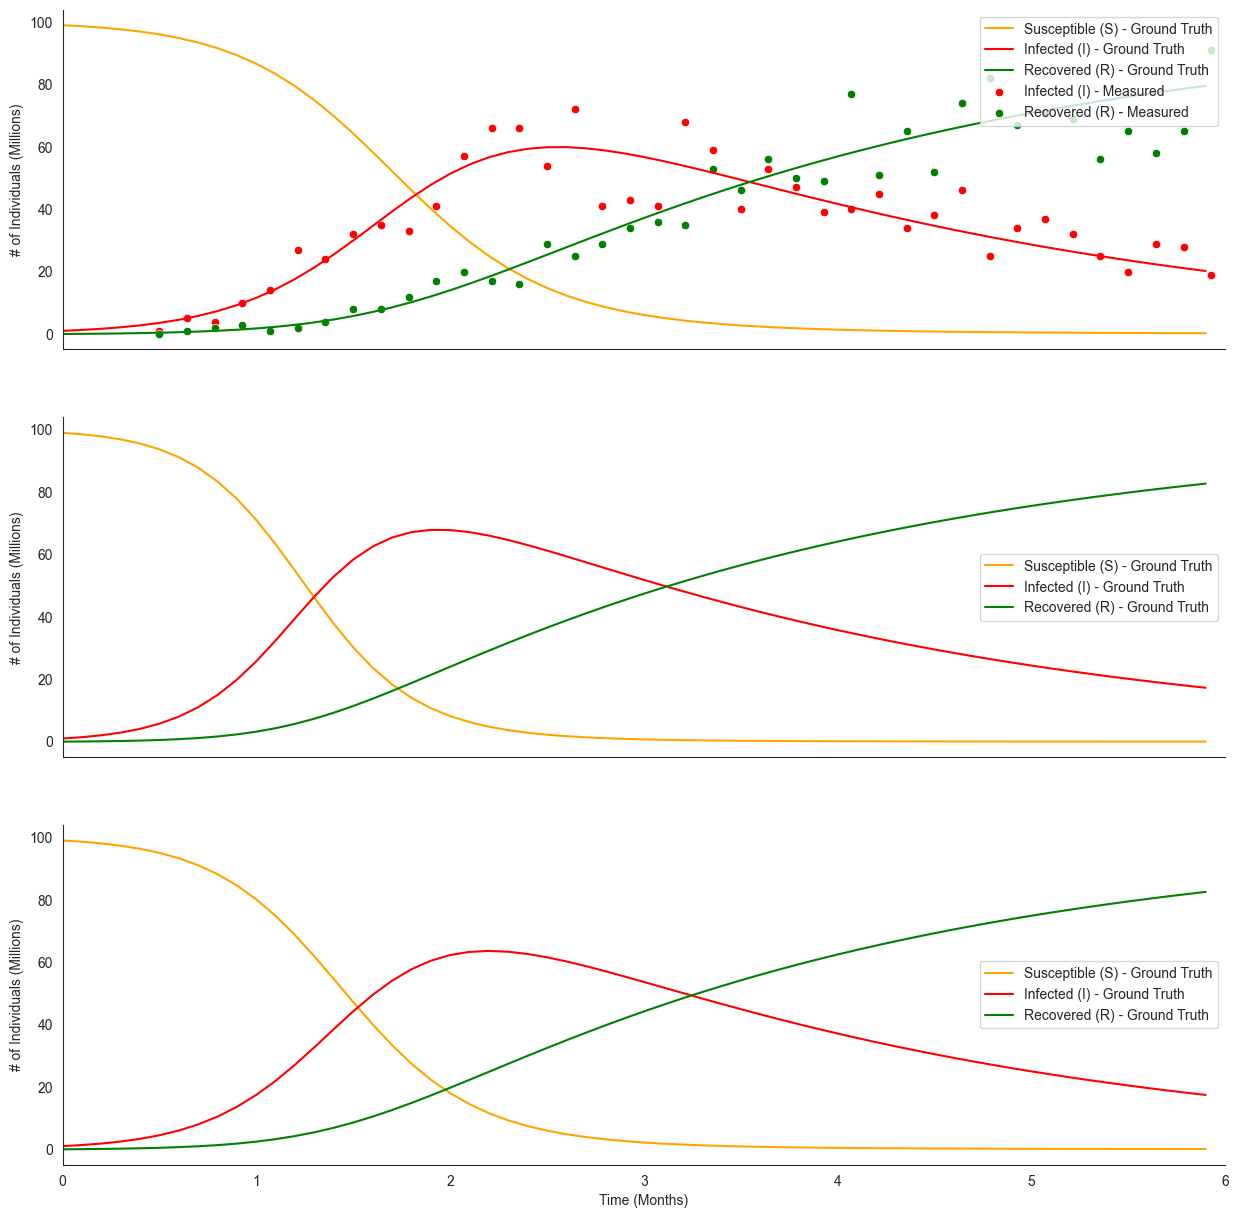

In [4]:

fig, axes = plt.subplots(n_stratum, 1, figsize=(15, 15), sharex=True)
for i in range(n_stratum):
    ax = axes[i]
    sns.lineplot(
        x=logging_times, y=sir_true_traj["S"][i, :], label="Susceptible (S) - Ground Truth", color="orange", ax=ax
    )
    sns.lineplot(x=logging_times, y=sir_true_traj["I"][i, :], label="Infected (I) - Ground Truth", color="red", ax=ax)
    sns.lineplot(x=logging_times, y=sir_true_traj["R"][i, :], label="Recovered (R) - Ground Truth", color="green", ax=ax)
    if i == 0:
        sns.scatterplot(x=obs_logging_times, y=sir_data["I_obs"], label="Infected (I) - Measured", color="red", ax=ax)
        sns.scatterplot(x=obs_logging_times, y=sir_data["R_obs"], label="Recovered (R) - Measured", color="green", ax=ax)
        ax.legend(loc="upper right")
    sns.despine()

    ax.set_xlim(start_time, end_time)
    ax.set_ylabel("# of Individuals (Millions)")

plt.xlabel("Time (Months)")
    
    

## Bayesian Partial Pooling with Dynamical Systems

In [5]:
from typing import Callable

def reparameterize_inverse_gamma(mean, std):
    # alpha = mean ** 2 / variance
    # beta = mean * alpha
    alpha = 2 + mean ** 2 / std ** 2
    beta = mean * (alpha - 1)
    return alpha, beta

def bayesian_multilevel_sir(n_stratum: int, base_model: Callable[[torch.Tensor], Dynamics[torch.Tensor]]=SIRDynamics) -> Dynamics[torch.Tensor]:
    beta_mean = pyro.sample("beta_mean", dist.Beta(1, 10))
    beta_std = 0.01
    
    gamma_mean = pyro.sample("gamma_mean", dist.Beta(10, 10))
    gamma_std = 0.01
    
    with pyro.plate("stratum", size=n_stratum, dim=-1):
        beta = pyro.sample("beta", dist.InverseGamma(*reparameterize_inverse_gamma(beta_mean, beta_std)))
        gamma = pyro.sample("gamma", dist.InverseGamma(*reparameterize_inverse_gamma(gamma_mean, gamma_std)))
    sir = base_model(beta, gamma)
    return sir

def simulated_multilevel_bayesian_sir(init_state, start_time, logging_times, base_model=SIRDynamics) -> State[torch.Tensor]:
    n_stratum = init_state["S"].shape[-1]
    assert init_state["I"].shape[-1] == init_state["R"].shape[-1] == n_stratum
    sir = bayesian_multilevel_sir(n_stratum, base_model)
    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt:
        simulate(sir, init_state, start_time, logging_times[-1])
    return lt.trajectory

In [6]:
prior_predictive = Predictive(simulated_multilevel_bayesian_sir, num_samples=num_samples, parallel=True)
prior_samples = prior_predictive(init_state, start_time, logging_times)

In [7]:
def SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax, mean_label="Posterior Mean"):
    sns.lineplot(
        x=time_period,
        y=state_pred.mean(dim=0),
        color=color,
        label=mean_label,
        ax=ax,
    )
    # 95% Credible Interval
    ax.fill_between(
        time_period,
        torch.quantile(state_pred, 0.025, dim=0),
        torch.quantile(state_pred, 0.975, dim=0),
        alpha=0.2,
        color=color,
        label="95% Credible Interval",
    )

    ax.set_xlabel("Time (Months)")
    ax.set_ylabel(ylabel)


def SIR_data_plot(time_period, data, data_label, ax):
    sns.lineplot(
        x=time_period, y=data, color="black", ax=ax, linestyle="--", label=data_label
    )


def SIR_test_plot(test_start_time, test_end_time, ax):
    ax.axvline(
        test_start_time, color="black", linestyle=":", label="Measurement Period"
    )
    ax.axvline(
        test_end_time, color="black", linestyle=":"
    )


def SIR_plot(
    time_period,
    state_pred,
    data,
    ylabel,
    color,
    data_label,
    ax,
    legend=False,
    test_plot=True,
    test_start_time=obs_start_time,
    test_end_time=obs_end_time,
    mean_label="Posterior Mean",
):
    SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax, mean_label=mean_label)
    SIR_data_plot(time_period, data, data_label, ax)
    if test_plot:
        SIR_test_plot(test_start_time, test_end_time, ax)
    if legend:
        ax.legend()
    else:
        ax.legend().remove()
    sns.despine()

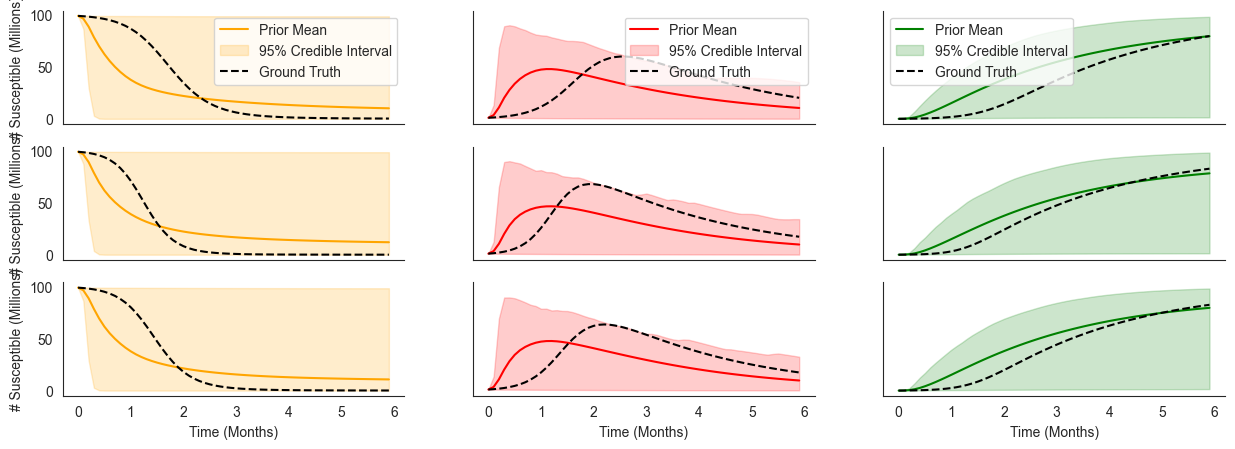

In [8]:

fig, ax = plt.subplots(n_stratum, 3, figsize=(15, 5), sharex=True, sharey=True)

for i in range(n_stratum):

    if i == 0:
        legend = True
    else:
        legend = False
    SIR_plot(
        logging_times,
        prior_samples["S"][..., 0, i, :],
        sir_true_traj["S"][i, :], 
        "# Susceptible (Millions)",
        "orange",
        "Ground Truth",
        ax[i, 0],
        legend=legend,
        test_plot=False,
        mean_label="Prior Mean",
    )

    SIR_plot(
        logging_times,
        prior_samples["I"][..., 0, i, :],
        sir_true_traj["I"][i, :],
        "# Infected (Millions)",
        "red",
        "Ground Truth",
        ax[i, 1],
        legend=legend,
        test_plot=False,
        mean_label="Prior Mean",
    )

    SIR_plot(
        logging_times,
        prior_samples["R"][..., 0, i, :],
        sir_true_traj["R"][i, :],
        "# Recovered (Millions)",
        "green",
        "Ground Truth",
        ax[i, 2],
        legend=legend,
        test_plot=False,
        mean_label="Prior Mean",
    )

Here, we can see that without any data our prior has induced extremely broad uncertainty over resulting disease dynamics.

## Probabilistic Inference over Dynamical System Parameters

One of the major benefits of writing our dynamical systems model in Pyro and ChiRho is that we can leverage Pyro's support for (partially) automated probabilistic inference. In this section we'll (i) condition on observational data using the `StaticBatchObservation` effect handler and (ii) optimize a variational approximation to the posterior using Pyro's SVI utilities.

In [9]:
def conditioned_sir(obs_times, data, init_state, start_time, base_model=SIRDynamics) -> None:
    n_stratum = init_state["S"].shape[-1]
    assert init_state["I"].shape[-1] == init_state["R"].shape[-1] == n_stratum

    sir = bayesian_multilevel_sir(n_stratum, base_model)

    obs = condition(data=data)(single_observation_model)
    with TorchDiffEq(), StaticBatchObservation(obs_times, observation=obs):
        simulate(sir, init_state, start_time, obs_times[-1])

# Define a helper function to run SVI. (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(model, num_steps=num_steps, verbose=True, lr=.03, vi_family=AutoMultivariateNormal, guide=None, **model_kwargs):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, num_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 25 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [10]:
from pyro.infer.autoguide import AutoLowRankMultivariateNormal

# Run inference to approximate the posterior distribution of the SIR model parameters
sir_guide = run_svi_inference(
    conditioned_sir,
    num_steps=num_steps,
    obs_times=obs_logging_times,
    data=sir_data,
    init_state=init_state,
    start_time=start_time,
    vi_family=AutoLowRankMultivariateNormal,
)

[iteration 0001] loss: 1349.8151
[iteration 0025] loss: 494.0382
[iteration 0050] loss: 260.2583
[iteration 0075] loss: 267.0822
[iteration 0100] loss: 269.6343
[iteration 0125] loss: 263.7554
[iteration 0150] loss: 259.4420
[iteration 0175] loss: 258.7310
[iteration 0200] loss: 259.8893


### Informal Posterior Predictive Check - Visualizing Samples

Now that we've approximated the posterior distribution over parameters, let's see how the posterior samples compare to the ground truth parameters and disease trajectories.

In [11]:
# Generate samples from the posterior predictive distribution
sir_predictive = Predictive(simulated_multilevel_bayesian_sir, guide=sir_guide, num_samples=num_samples, parallel=True)
sir_posterior_samples = sir_predictive(init_state, start_time, logging_times)

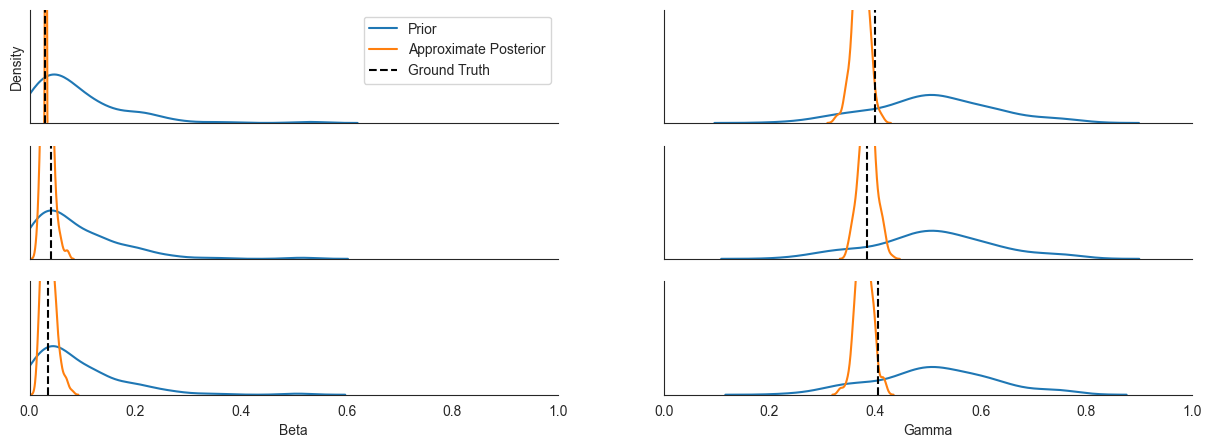

In [12]:
fig, ax = plt.subplots(n_stratum, 2, figsize=(15, 5), sharex=True, sharey=True)

for i in range(n_stratum):
    sns.kdeplot(prior_samples["beta"][..., i], label="Prior", ax=ax[i, 0])
    sns.kdeplot(sir_posterior_samples["beta"][..., i], label="Approximate Posterior", ax=ax[i, 0])
    ax[i, 0].axvline(beta_true[i], color="black", label="Ground Truth", linestyle="--")
    sns.despine()
    ax[i, 0].set_yticks([])
    ax[i, 0].set_xlabel("Beta")
    ax[i, 0].set_xlim(0, 1.0)
    ax[i, 0].set_ylim(0, 15)

    sns.kdeplot(prior_samples["gamma"][..., i], ax=ax[i, 1])
    sns.kdeplot(sir_posterior_samples["gamma"][..., i], ax=ax[i, 1])
    ax[i, 1].axvline(gamma_true[i], color="black", linestyle="--")
    sns.despine()
    ax[i, 1].set_yticks([])
    ax[i, 1].set_xlabel("Gamma")
    ax[i, 1].set_xlim(0, 1.0)

ax[0, 0].legend(loc="upper right")

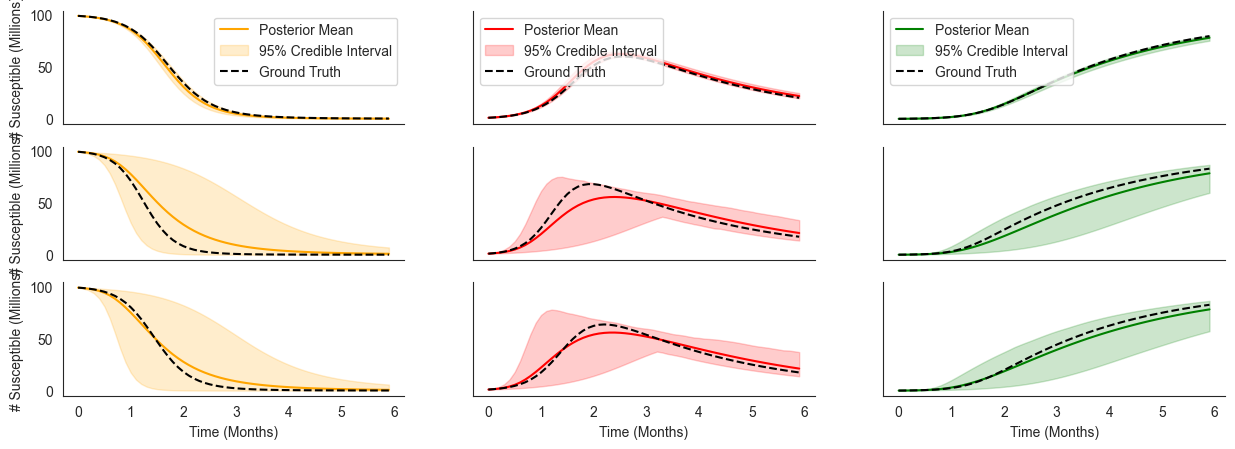

In [13]:
fig, ax = plt.subplots(n_stratum, 3, figsize=(15, 5), sharex=True, sharey=True)

for i in range(n_stratum):

    if i == 0:
        legend = True
    else:
        legend = False
    SIR_plot(
        logging_times,
        sir_posterior_samples["S"][..., 0, i, :],
        sir_true_traj["S"][i, :], 
        "# Susceptible (Millions)",
        "orange",
        "Ground Truth",
        ax[i, 0],
        legend=legend,
        test_plot=False,
        mean_label="Posterior Mean",
    )

    SIR_plot(
        logging_times,
        sir_posterior_samples["I"][..., 0, i, :],
        sir_true_traj["I"][i, :],
        "# Infected (Millions)",
        "red",
        "Ground Truth",
        ax[i, 1],
        legend=legend,
        test_plot=False,
        mean_label="Posterior Mean",
    )

    SIR_plot(
        logging_times,
        sir_posterior_samples["R"][..., 0, i, :],
        sir_true_traj["R"][i, :],
        "# Recovered (Millions)",
        "green",
        "Ground Truth",
        ax[i, 2],
        legend=legend,
        test_plot=False,
        mean_label="Posterior Mean",
    )